# Task 3
finish time: 4h

## Import libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Data overview

In [2]:
# load data
vehicles_df = pd.read_csv('vehicles.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,74,76) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vehicles_df.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,...,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,2000,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,...,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0000,0.0,Two Seaters,1985,-2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3850,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,...,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0000,0.0,Two Seaters,1985,-11500,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1550,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,...,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0000,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.2,Rear-Wheel Drive,2850,NaN,-1,3850,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,...,1000,0,0,Dodge,B150/B250 Wagon 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.2222,0.0,16.6667,0.0,Vans,1985,-11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2700,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,...,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [4]:
vehicles_df.shape

(40081, 83)

In [5]:
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40081 entries, 0 to 40080
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        40081 non-null  float64
 1   barrelsA08       40081 non-null  float64
 2   charge120        40081 non-null  float64
 3   charge240        40081 non-null  float64
 4   city08           40081 non-null  int64  
 5   city08U          40081 non-null  float64
 6   cityA08          40081 non-null  int64  
 7   cityA08U         40081 non-null  float64
 8   cityCD           40081 non-null  float64
 9   cityE            40081 non-null  float64
 10  cityUF           40081 non-null  float64
 11  co2              40081 non-null  int64  
 12  co2A             40081 non-null  int64  
 13  co2TailpipeAGpm  40081 non-null  float64
 14  co2TailpipeGpm   40081 non-null  float64
 15  comb08           40081 non-null  int64  
 16  comb08U          40081 non-null  float64
 17  combA08     

In [6]:
vehicles_df.describe()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,engId,feScore,fuelCost08,fuelCostA08,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb
count,40081.000000,40081.000000,40081.0,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,39910.000000,39912.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.00000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000,40081.000000
mean,17.363564,0.220069,0.0,0.036086,18.213318,5.494777,0.616077,0.466164,0.000471,0.274113,0.001279,80.114069,5.713131,17.719449,468.544572,20.461890,6.149154,0.677104,0.504176,0.280361,0.000363,0.001261,5.721949,3.301581,8377.335695,0.238891,2377.809935,90.062623,0.237020,-0.922357,24.350989,7.282794,0.782590,0.575074,0.000242,0.288492,0.001237,2.019585,10.355630,20153.739777,1.814675,6.139243,13.556224,33.823383,0.616377,0.578557,0.067532,0.56391,0.062571,22.981798,0.789437,34.105932,1.076877,2001.068586,-4134.565006,0.007497,0.122851,0.123375,0.122527
std,4.597119,1.143270,0.0,0.534894,7.397433,11.027993,4.739349,4.563736,0.039282,3.513989,0.026025,169.097121,56.593602,93.570154,122.860412,7.241669,11.763417,4.812536,4.583432,3.570188,0.034418,0.025634,1.754891,1.359536,17438.287043,2.609123,650.164538,472.905402,2.605921,0.655249,7.399345,13.320198,5.078711,4.771112,0.028777,3.658540,0.025164,5.947612,28.114545,11693.824834,4.378800,9.679641,31.105515,46.001847,11.133278,10.975931,1.639622,11.06548,1.479728,10.473444,6.612445,10.790921,7.205627,10.908967,3256.499139,0.195365,2.599224,2.510273,2.542274
min,0.060000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-1.000000,500.000000,0.000000,-1.000000,-1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1984.000000,-29000.000000,0.000000,0.000000,0.000000,0.000000
25%,14.330870,0.000000,0.0,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,386.391304,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200000,0.000000,-1.000000,1950.000000,0.000000,-1.000000,-1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10021.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,18.110500,0.000000,27.661300,0.000000,1991.000000,-5750.000000,0.000000,0.000000,0.000000,0.000000
50%,16.480500,0.000000,0.0,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,447.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,186.000000,-1.000000,2350.000000,0.000000,-1.000000,-1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20042.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,21.296500,0.000000,33.024600,0.000000,2002.000000,-

We can see, firstly a few columns have a lot of nulls, I am considering remove them later if they are useless or have little correlation with the predicted field. Also there are too many columns, it may affect the performance of the regression model causing overfitting, feature selection is needed. Secondly, each column have different scale, so scaler will be used to transform data. Third, most columns are numeric, but the categorical columns, e.g 'make' and 'model' will be encoded.

## EDA

### The most fuel effective producer is Tesla.

In [79]:
top10_fuel_producer = vehicles_df.groupby(['make'])['UCity'].mean().sort_values(ascending=False)[:10]

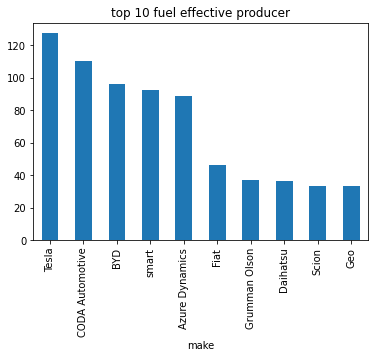

In [80]:
top10_fuel_producer.plot(kind='bar', title = 'top 10 fuel effective producer')

### The most cost efficient producer is Tesla, some fuel effective producer are not always cost efficient, you spent some money to support fuel effective, but it is still economic than other non-fuel-effective producers.

In [81]:
top10_cost_producer = vehicles_df.groupby(['make'])['youSaveSpend'].mean().sort_values(ascending=False)[:10]

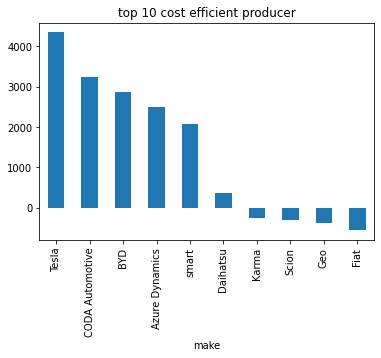

In [82]:
top10_cost_producer.plot(kind='bar', title = 'top 10 cost efficient producer')

### The most fuel effective model is Ioniq Electric from Hyundai, which has an average mpg over 220. Although on average Tesla is the most fuel effective producer, the most fuel effective model in Tesla is Model 3 Long Range, which ranks 5 out of 10.

In [87]:
top10_fuel_model = vehicles_df.groupby(['make', 'model'])['UCity'].mean().sort_values(ascending=False)[:10]

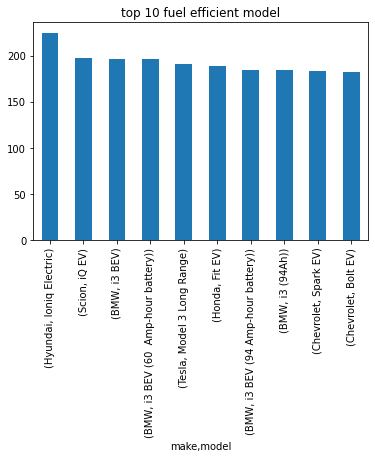

In [90]:
top10_fuel_model.plot(kind='bar', title = 'top 10 fuel efficient model')

### Model 3 Long Range from Tesla is the most cost efficient model, which saves more than 5000 over 5 years compared to an average car ($). Another competetive model is Ioniq Electric from Hyundai. The rest 8 models are also very economic. Most of the models also proofed to be fuel effective as well.

In [89]:
top10_cost_model = vehicles_df.groupby(['make', 'model'])['youSaveSpend'].mean().sort_values(ascending=False)[:10]

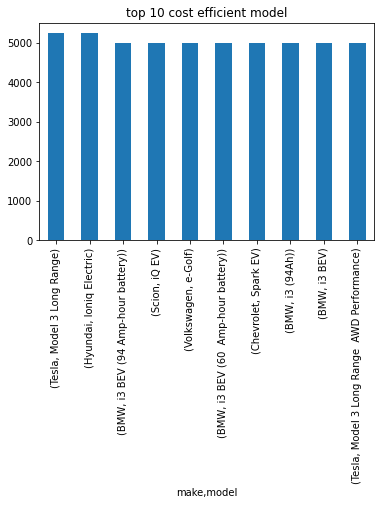

In [91]:
top10_cost_model.plot(kind='bar', title = 'top 10 cost efficient model')

### In conclusion, the electric car is a tendency because they are both fuel-effective and cost-efficient in the long run.

## Data cleaning

1. Remove less related fields according to correlation with the predicted field
2. Drop high null rate columns
3. Drop informativeless column due to field meaning
4. Drop nulls
5. Scaler
6. LabelEncoder

In [7]:
# check relationship between each numerical column and predicted field
corr = vehicles_df.corr()['UCity'].abs().sort_values(ascending=False)
corr

UCity              1.000000
city08             0.997167
comb08             0.983986
highway08          0.925728
UHighway           0.924505
co2TailpipeGpm     0.725386
displ              0.713249
barrels08          0.712469
cylinders          0.679927
youSaveSpend       0.658371
fuelCost08         0.657363
city08U            0.638491
charge240          0.623996
range              0.601359
rangeCity          0.593646
comb08U            0.587552
rangeHwy           0.560807
highwayE           0.520141
highway08U         0.516126
combE              0.504884
cityE              0.490125
charge240b         0.411088
feScore            0.397834
ghgScore           0.397378
hpv                0.256158
hlv                0.229395
id                 0.186948
year               0.171466
pv4                0.156416
lv4                0.122900
phevCity           0.109815
phevComb           0.109099
phevHwy            0.107345
cityUF             0.098911
combinedUF         0.097910
highwayUF          0

In [8]:
# set the threshold to be 0.2, drop numeric columns that are not so related to predicted field
num_cols = corr[corr < 0.2].index

In [9]:
null_rate = vehicles_df.isnull().sum()/len(vehicles_df)

In [10]:
# drop the columns that null rate is greater than 80%
null_cols = null_rate[null_rate > 0.5].index

In [11]:
null_cols

Index(['guzzler', 'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2',
       'rangeA', 'evMotor', 'mfrCode', 'c240Dscr', 'c240bDscr', 'startStop'],
      dtype='object')

In [12]:
# attention: charge120 is not null, but it is 0 for each row, not informative, need to drop
# createdOn, modifiedOn, startStop are not informative, drop them
df_cleaned = vehicles_df.drop(num_cols, axis=1)
df_cleaned = df_cleaned.drop(null_cols, axis=1)
df_cleaned = df_cleaned.drop('charge120', axis=1)
df_cleaned = df_cleaned.drop(['createdOn', 'modifiedOn', 'eng_dscr'], axis=1)

In [13]:
df_cleaned.shape

(40081, 34)

In [15]:
df_cleaned.isnull().sum()

barrels08            0
charge240            0
city08               0
city08U              0
cityE                0
co2TailpipeGpm       0
comb08               0
comb08U              0
combE                0
cylinders          171
displ              169
drive             1189
feScore              0
fuelCost08           0
fuelType             0
fuelType1            0
ghgScore             0
highway08            0
highway08U           0
highwayE             0
hlv                  0
hpv                  0
make                 0
model                0
mpgData              0
range                0
rangeCity            0
rangeHwy             0
trany               11
UCity                0
UHighway             0
VClass               0
youSaveSpend         0
charge240b           0
dtype: int64

In [16]:
# drop rows that have null values for convenience
df_cleaned = df_cleaned.dropna(axis=0)

In [17]:
df_cleaned.shape

(38727, 34)

In [18]:
df_cleaned.head()

,barrels08,charge240,city08,city08U,cityE,co2TailpipeGpm,comb08,comb08U,combE,cylinders,displ,drive,feScore,fuelCost08,fuelType,fuelType1,ghgScore,highway08,highway08U,highwayE,hlv,hpv,make,model,mpgData,range,rangeCity,rangeHwy,trany,UCity,UHighway,VClass,youSaveSpend,charge240b
0,15.695714,0.0,19,0.0,0.0,423.190476,21,0.0,0.0,4.0,2.0,Rear-Wheel Drive,-1,2000,Regular,Regular Gasoline,-1,25,0.0,0.0,0,0,Alfa Romeo,Spider Veloce 2000,Y,0,0.0,0.0,Manual 5-spd,23.3333,35.0000,Two Seaters,-2250,0.0
1,29.964545,0.0,9,0.0,0.0,807.909091,11,0.0,0.0,12.0,4.9,Rear-Wheel Drive,-1,3850,Regular,Regular Gasoline,-1,14,0.0,0.0,0,0,Ferrari,Testarossa,N,0,0.0,0.0,Manual 5-spd,11.0000,19.0000,Two Seaters,-11500,0.0
2,12.207778,0.0,23,0.0,0.0,329.148148,27,0.0,0.0,4.0,2.2,Front-Wheel Drive,-1,1550,Regular,Regular Gasoline,-1,33,0.0,0.0,19,77,Dodge,Charger,Y,0,0.0,0.0,Manual 5-spd,29.0000,47.0000,Subcompact Cars,0,0.0
3,29.964545,0.0,10,0.0,0.0,807.909091,11,0.0,0.0,8.0,5.2,Rear-Wheel Drive,-1,3850,Regular,Regular Gasoline,-1,12,0.0,0.0,0,0,Dodge,B150/B250 Wagon 2WD,N,0,0.0,0.0,Automatic 3-spd,12.2222,16.6667,Vans,-11500,0.0
4,17.347895,0.0,17,0.0,0.0,467.736842,19,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,-1,2700,Premium,Premium Gasoline,-1,23,0.0,0.0,0,0,Subaru,Legacy AWD Turbo,N,0,0.0,0.0,Manual 5-spd,21.0000,32.0000,Compact Cars,-5750,0.0


In [19]:
categorical_cols = ['drive', 'fuelType', 'fuelType1', 'make', 'model', 'mpgData', 'trany', 'VClass']
df_final = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

In [20]:
df_final.head()

,barrels08,charge240,city08,city08U,cityE,co2TailpipeGpm,comb08,comb08U,combE,cylinders,displ,feScore,fuelCost08,ghgScore,highway08,highway08U,highwayE,hlv,hpv,range,rangeCity,rangeHwy,UCity,UHighway,youSaveSpend,charge240b,drive_4-Wheel Drive,drive_4-Wheel or All-Wheel Drive,drive_All-Wheel Drive,drive_Automatic (A1),drive_Front-Wheel Drive,drive_Part-time 4-Wheel Drive,drive_Rear-Wheel Drive,fuelType_Diesel,fuelType_Gasoline or E85,fuelType_Gasoline or natural gas,fuelType_Gasoline or propane,fuelType_Midgrade,fuelType_Premium,fuelType_Premium Gas or Electricity,...,trany_Automatic 8-spd,trany_Automatic 9-spd,trany_Manual 3-spd,trany_Manual 4-spd,trany_Manual 5-spd,trany_Manual 6-spd,trany_Manual 7-spd,VClass_Large Cars,VClass_Midsize Cars,VClass_Midsize Station Wagons,VClass_Midsize-Large Station Wagons,VClass_Minicompact Cars,VClass_Minivan - 2WD,VClass_Minivan - 4WD,VClass_Small Pickup Trucks,VClass_Small Pickup Trucks 2WD,VClass_Small Pickup Trucks 4WD,VClass_Small Sport Utility Vehicle 2WD,VClass_Small Sport Utility Vehicle 4WD,VClass_Small Station Wagons,VClass_Special Purpose Vehicle,VClass_Special Purpose Vehicle 2WD,VClass_Special Purpose Vehicle 4WD,VClass_Special Purpose Vehicles,VClass_Special Purpose Vehicles/2wd,VClass_Special Purpose Vehicles/4wd,VClass_Sport Utility Vehicle - 2WD,VClass_Sport Utility Vehicle - 4WD,VClass_Standard Pickup Trucks,VClass_Standard Pickup Trucks 2WD,VClass_Standard Pickup Trucks 4WD,VClass_Standard Pickup Trucks/2wd,VClass_Standard Sport Utility Vehicle 2WD,VClass_Standard Sport Utility Vehicle 4WD,VClass_Subcompact Cars,VClass_Two Seaters,VClass_Vans,VClass_Vans Passenger,"VClass_Vans, Cargo Type","VClass_Vans, Passenger Type"
0,15.695714,0.0,19,0.0,0.0,423.190476,21,0.0,0.0,4.0,2.0,-1,2000,-1,25,0.0,0.0,0,0,0,0.0,0.0,23.3333,35.0000,-2250,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,29.964545,0.0,9,0.0,0.0,807.909091,11,0.0,0.0,12.0,4.9,-1,3850,-1,14,0.0,0.0,0,0,0,0.0,0.0,11.0000,19.0000,-11500,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,12.207778,0.0,23,0.0,0.0,329.148148,27,0.0,0.0,4.0,2.2,-1,1550,-1,33,0.0,0.0,19,77,0,0.0,0.0,29.0000,47.0000,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,29.964545,0.0,10,0.0,0.0,807.909091,11,0.0,0.0,8.0,5.2,-1,3850,-1,12,0.0,0.0,0,0,0,0.0,0.0,12.2222,16.6667,-11500,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,17.347895,0.0,17,0.0,0.0,467.736842,19,0.0,0.0,4.0,2.2,-1,2700,-1,23,0.0,0.0,0,0,0,0.0,0.0,21.0000,32.0000,-5750,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data modelling

1. Split data into train, test
2. Create pipeline, PCA (feature compression), ML models
3. Train multiple ML models with cross-validation

In [22]:
y = df_final['UCity']

In [23]:
X = df_final.drop('UCity', axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [46]:
pipeline_lr = Pipeline([('stdScaler', StandardScaler()), \
                        ('pca', PCA(n_components=10)), \
                        ('lr', LinearRegression())])

In [49]:
pipeline_dt = Pipeline([('stdScaler', StandardScaler()), \
                        ('pca', PCA(n_components=10)), \
                        ('dt', DecisionTreeRegressor())])

In [52]:
pipeline_rf = Pipeline([('stdScaler', StandardScaler()), \
                        ('pca', PCA(n_components=10)), \
                        ('rf', RandomForestRegressor())])

In [56]:
pipeline_gt = Pipeline([('stdScaler', StandardScaler()), \
                        ('pca', PCA(n_components=10)), \
                        ('gt', GradientBoostingRegressor())])

In [61]:
pipelines = []
pipelines.append(('LR', pipeline_lr))
pipelines.append(('DT', pipeline_dt))
pipelines.append(('RF', pipeline_rf))
pipelines.append(('GT', pipeline_gt))

In [63]:
results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
    results.append(cv_results)
    names.append(name)
    message = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(message)

LR: -5.769438 (0.229162)
DT: -1.696717 (0.162818)
RF: -0.987444 (0.035462)
GT: -1.812426 (0.109576)


Roughly, we can see random forest has better performance.

## Data evaluation

1. Compare models
2. Select the best one based on overall performance
3. Test performance on test data

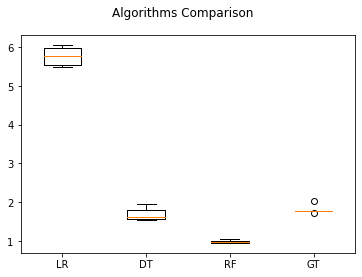

In [64]:
fig = plt.figure()
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

By plotting, we can confirm we will choose random forest as the optimal model.

In [65]:
# test data
pipeline_rf.fit(X_train, y_train)
y_predict = pipeline_rf.predict(X_test)
mean_squared_error(y_test, y_predict)

0.9295477044916826

Test performance is also good, though we cannot see the feature importance due to PCA.

Future work should be tune the hyperparameter in PCA, such as n_components that in random forest, such as, num_trees, using GridSearch.